# Analyzing our results

In the first tutorial you learned how to load and interpret our published barrier results. Here you'll explore and analyze the data.

Let's first start with imports:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import nglview as nv
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import stats
import json

And then load the JSON file:

In [3]:
with open("data/ts_query.json", 'r') as f:
    info = json.load(f)


## Effective activation entropies
We can look at the distribution of effective activation entropies, and see if the range roughly matches experimental ranges for different derivatives:

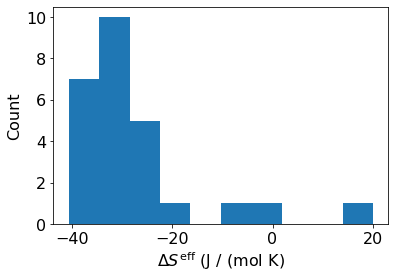

In [4]:
rcParams.update({"font.size": 16})

def get_quants(info, key):
    lst = []
    for smiles, sub_dic in info.items():
        summary = sub_dic['summary']
        if 's_t_crossing' not in summary:
            continue
        st_dic = summary['s_t_crossing']
        val = st_dic['unstable_side'][key]
        lst.append(val)
    return lst

dS_eff_list = get_quants(info, 'delta_eff_entropy_j_mol_k')
    
plt.hist(dS_eff_list)
plt.xlabel("$\Delta S^{\mathrm{eff}}$ ($\mathrm{J} \  / \ (\mathrm{mol \ K})$")
plt.ylabel("Count")
plt.show()

The peak is at $-30 \ \mathrm{J} \  / \ (\mathrm{mol \ K})$, which is close to the measured value for azobenzene. The range is from around $-40$ to $20 \ \mathrm{J} \  / \ (\mathrm{mol \ K})$.

## Intersystem crossing rates
We can look at the distribution of intersystem crossing rates:

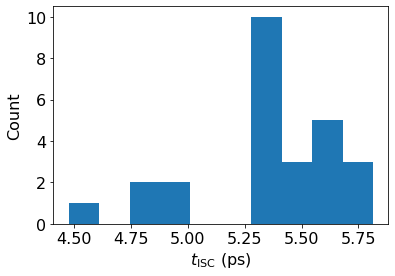

In [5]:
t_isc_list = np.array(get_quants(info, 't_isc')) / 1e-12

plt.hist(t_isc_list)
plt.xlabel("$t_{\mathrm{ISC}} \ (\mathrm{ps})$")
plt.ylabel("Count")
plt.show()

We see that most of the species have an intersystem crossing rate of $1 \ / \ (5.3  \ \mathrm{ps})$, which is within a factor of two of the result in [this paper](https://pubs.acs.org/doi/full/10.1021/ja038327y). 

## Actual activation entropies

We can also look at the actual activation entropies, and decompose them into vibrational and conformational contributions:

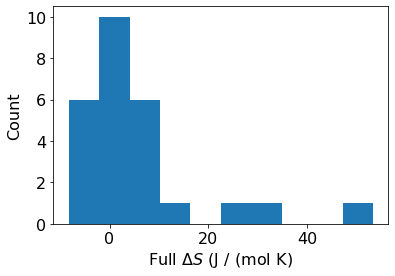

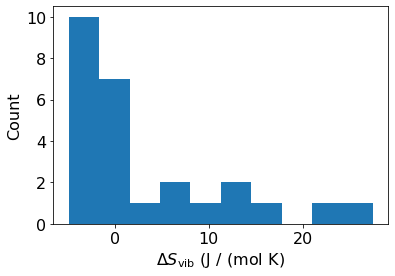

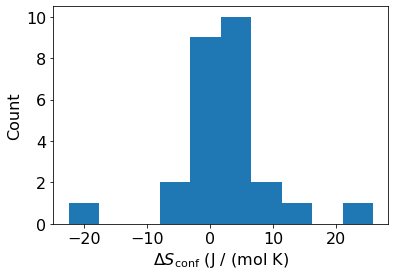

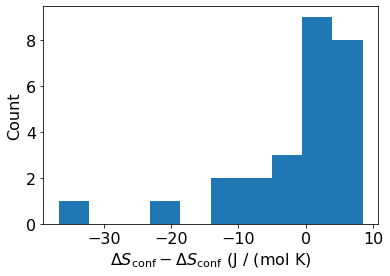

In [6]:
dS_list = np.array(get_quants(info, 'delta_entropy_j_mol_k'))
dS_vib_list = np.array(get_quants(info, 'delta_vib_entropy_j_mol_k'))
dS_conf_list = np.array(get_quants(info, 'delta_conf_entropy_j_mol_k'))

results = {r"Full $\Delta S \ (\mathrm{J} \  / \ (\mathrm{mol \ K})$": dS_list,
           r"$\Delta S_{\mathrm{vib}} \ (\mathrm{J} \  / \ (\mathrm{mol \ K})$": dS_vib_list,
           r"$\Delta S_{\mathrm{conf}} \ (\mathrm{J} \  / \ (\mathrm{mol \ K})$": dS_conf_list,
           (r"$\Delta S_{\mathrm{conf}} - \Delta S_{\mathrm{conf}}  \ "
            "(\mathrm{J} \  / \ (\mathrm{mol \ K})$"): dS_conf_list - dS_vib_list}

for key, conf_list in results.items():
    plt.hist(conf_list)
    plt.xlabel(key)
    plt.ylabel("Count")
    plt.show()



We see that the range of $\Delta S_{\mathrm{vib}}$ is around $-5$ to $25$ $\mathrm{J} \  / \ \mathrm{mol \ K}$, while $\Delta S_{\mathrm{conf}}$ has a range between $-20$ and $20 \ \mathrm{J} \  / \ \mathrm{mol \ K}$. $\Delta S_{\mathrm{conf}}$ tends to be more negative than $\Delta S_{\mathrm{vib}}$.

## Free energies
Let's look at effective free energies from singlet-triplet crossings, and activation free energies from TSs:

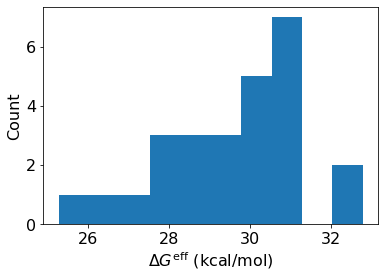

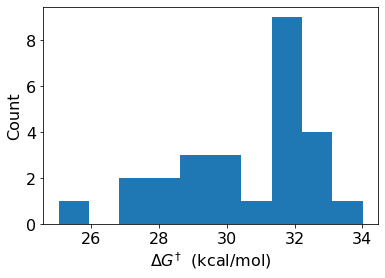

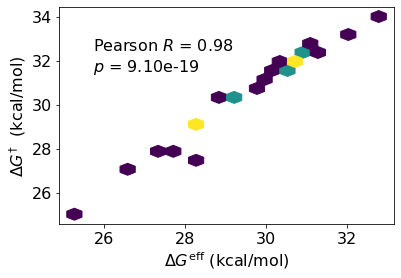

In [7]:


dG_lst = []
dG_eff_lst = []


for smiles, sub_dic in info.items():
    summary = sub_dic['summary']
    if 's_t_crossing' not in summary:
        continue
    st_dic = summary['s_t_crossing']
    eff_dG = st_dic['unstable_side']['delta_eff_free_energy']
    unstable = sub_dic['unstable']
    dG = sub_dic['summary'][unstable]['delta_free_energy']
    
    dG_eff_lst.append(eff_dG)
    dG_lst.append(dG)

    
plt.hist(dG_eff_lst)
plt.xlabel("$\Delta G^{\mathrm{eff}}$ (kcal/mol)")
plt.ylabel("Count")
plt.show()

plt.hist(dG_lst)
plt.xlabel("$\Delta G^{\dagger}$  (kcal/mol)")
plt.ylabel("Count")
plt.show()

pearson, p = stats.pearsonr(dG_eff_lst, dG_lst)

fig, ax = plt.subplots()
plt.text(0.1, 0.8, "Pearson $R$ = %.2f" % pearson,
         transform=ax.transAxes)
plt.text(0.1, 0.7, "$p$ = %.2e" % p,
         transform=ax.transAxes)

plt.hexbin(dG_eff_lst, 
           dG_lst,
           mincnt=1,
           gridsize=20)
plt.xlabel("$\Delta G^{\mathrm{eff}}$ (kcal/mol)")
plt.ylabel("$\Delta G^{\dagger}$  (kcal/mol)")
plt.show()

We see that the two quantities are strongly correlated.

## Bell-Evans-Polanyi
The [BEP principle](https://en.wikipedia.org/wiki/Bell%E2%80%93Evans%E2%80%93Polanyi_principle) states that the activation energies of molecules in the same class is proportional to the reaction enthalpy. Let's test it out for our azobenzenes:

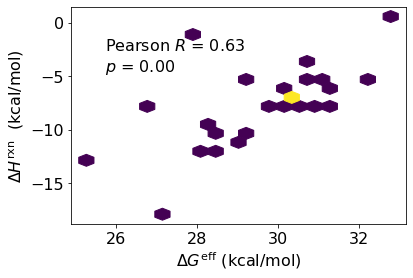

In [8]:
dH_rxn_list = []
dG_eff_lst = []

for smiles, sub_dic in info.items():
    summary = sub_dic['summary']
    if 's_t_crossing' not in summary:
        continue
    if not all([i in sub_dic for i in ['cis', 'trans']]):
        continue
        
    st_dic = summary['s_t_crossing']
    eff_dG = st_dic['unstable_side']['delta_eff_free_energy']
    unstable = sub_dic['unstable']
    
    # convert to kcal/mol
    if 'enthalpy' not in sub_dic['trans']:
        continue
        
    if 'enthalpy' not in sub_dic['cis']:
        continue
        
    dH_rxn = (sub_dic['trans']['enthalpy'] - sub_dic['cis']['enthalpy']) * 627.5
    
    dG_eff_lst.append(eff_dG)
    dH_rxn_list.append(dH_rxn)

pearson, p = stats.pearsonr(dG_eff_lst, dH_rxn_list)

fig, ax = plt.subplots()
plt.text(0.1, 0.8, "Pearson $R$ = %.2f" % pearson,
         transform=ax.transAxes)
plt.text(0.1, 0.7, "$p$ = %.2f" % p,
         transform=ax.transAxes)

plt.hexbin(dG_eff_lst, 
           dH_rxn_list,
           mincnt=1,
           gridsize=20)
plt.xlabel("$\Delta G^{\mathrm{eff}}$ (kcal/mol)")
plt.ylabel("$\Delta H^{\mathrm{rxn}}$  (kcal/mol)")
plt.show()


There seems to be a moderate correlation only! What about $\Delta G^{\dagger}$ and $\Delta H^{\mathrm{rxn}}$?

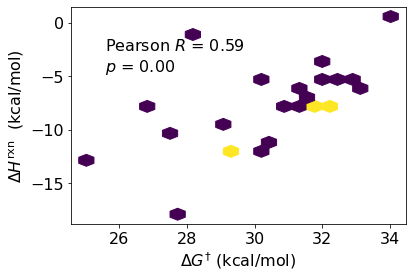

In [9]:
dH_rxn_list = []
dG_lst = []

for smiles, sub_dic in info.items():
    summary = sub_dic['summary']
    if 's_t_crossing' not in summary:
        continue
    if not all([i in sub_dic for i in ['cis', 'trans']]):
        continue
        
    st_dic = summary['s_t_crossing']
    unstable = sub_dic['unstable']
    dG = summary[unstable]['delta_free_energy']

    
    # convert to kcal/mol
    if 'enthalpy' not in sub_dic['trans']:
        continue
        
    if 'enthalpy' not in sub_dic['cis']:
        continue
        
    dH_rxn = (sub_dic['trans']['enthalpy'] - sub_dic['cis']['enthalpy']) * 627.5
    
    dG_lst.append(dG)
    dH_rxn_list.append(dH_rxn)

pearson, p = stats.pearsonr(dG_lst, dH_rxn_list)

fig, ax = plt.subplots()
plt.text(0.1, 0.8, "Pearson $R$ = %.2f" % pearson,
         transform=ax.transAxes)
plt.text(0.1, 0.7, "$p$ = %.2f" % p,
         transform=ax.transAxes)

plt.hexbin(dG_lst, 
           dH_rxn_list,
           mincnt=1,
           gridsize=20)
plt.xlabel("$\Delta G^{\mathrm{\dagger}}$ (kcal/mol)")
plt.ylabel("$\Delta H^{\mathrm{rxn}}$  (kcal/mol)")
plt.show()



The results are similar.